#Cell 1 — Notebook info & install requirements

In [11]:
# Cell 1 — Info & pip installs
# Run at start. Installs necessary libraries.

!pip install -q kaggle scikit-learn pandas matplotlib seaborn joblib nltk

# NLTK downloads used later (stopwords, punkt)
import nltk
nltk.download('stopwords')
nltk.download('punkt')

print("Packages installed. Ready.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...


Packages installed. Ready.


[nltk_data]   Unzipping tokenizers/punkt.zip.


#Cell 2 — Upload kaggle.json

In [12]:
# Cell 2 — Upload your kaggle.json (only once)
# In Colab: run this and use the file upload UI to upload kaggle.json
from google.colab import files
uploaded = files.upload()  # upload kaggle.json
for fn in uploaded.keys():
    print('Uploaded file:', fn)


Saving kaggle.json to kaggle.json
Uploaded file: kaggle.json


#Cell 3 — Configure Kaggle and download dataset

In [13]:
# Cell 3 — Move kaggle.json and download dataset from Kaggle
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Replace dataset identifier if you choose a different one:
# Recommended (combined TREC + Enron): purusinghvi/email-spam-classification-dataset
!kaggle datasets download -d purusinghvi/email-spam-classification-dataset -q -p /content/data/

# unzip
!unzip -o /content/data/email-spam-classification-dataset.zip -d /content/data/
!ls -lah /content/data


Dataset URL: https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset
License(s): MIT
Archive:  /content/data/email-spam-classification-dataset.zip
  inflating: /content/data/combined_data.csv  
total 177M
drwxr-xr-x 2 root root 4.0K Oct  3 08:39 .
drwxr-xr-x 1 root root 4.0K Oct  3 08:39 ..
-rw-r--r-- 1 root root 134M Nov  6  2023 combined_data.csv
-rw-r--r-- 1 root root  43M Nov  6  2023 email-spam-classification-dataset.zip


#Cell 4 — Imports & helper functions

In [14]:
# Cell 4 — imports
import pandas as pd
import numpy as np
import re, string, time, joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

print("Imports ready")


Imports ready


#Cell 5 — Load dataset (auto-detect common filenames)

In [15]:
# Cell 5 — Load CSV (tries common names; adjust filename if necessary)
import glob
csvs = glob.glob('/content/data/*.csv')
print("Found CSV files:", csvs)

# If there's more than one, choose the largest (most rows)
df = None
if len(csvs) == 0:
    raise FileNotFoundError("No CSV found in /content/data. Check dataset download.")
else:
    # load the largest CSV (heuristic)
    best=None; best_rows=-1
    for c in csvs:
        tmp = pd.read_csv(c, encoding='latin-1', low_memory=False)
        if tmp.shape[0] > best_rows:
            best = c; best_rows = tmp.shape[0]
    print("Loading:", best)
    df = pd.read_csv(best, encoding='latin-1', low_memory=False)

print("Initial shape:", df.shape)
df.head(5)


Found CSV files: ['/content/data/combined_data.csv']
Loading: /content/data/combined_data.csv
Initial shape: (83448, 2)


,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


#Cell 6 — Inspect & normalize columns

In [16]:
# Cell 6 — Inspect columns and normalize to 'label' and 'message'

print("Columns:", df.columns.tolist())

# Common Kaggle authors used: columns like 'label','message' or 'v1','v2'
if 'label' in df.columns and 'message' in df.columns:
    df = df[['label', 'message']].copy()
else:
    # try v1/v2
    if 'v1' in df.columns and 'v2' in df.columns:
        df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'}).copy()
    else:
        # try common alternatives
        # find the two text columns heuristically
        candidates = [c for c in df.columns if any(k in c.lower() for k in ['text', 'message', 'body', 'mail', 'content', 'subject'])]
        print("Candidate text-like columns:", candidates)
        # fallback: take the last two columns
        if len(candidates) >= 1:
            # pick first as message and a label-like column
            label_candidates = [c for c in df.columns if any(k in c.lower() for k in ['label', 'class', 'spam'])]
            if label_candidates:
                df = df[[label_candidates[0], candidates[0]]].rename(columns={label_candidates[0]: 'label', candidates[0]: 'message'}).copy()
            else:
                # fallback: assume first column is label, second is message
                df = df.iloc[:, :2].copy()
                df.columns = ['label', 'message']

print("After normalization shape:", df.shape)

# Ensure label and message are clean strings
df['label'] = df['label'].astype(str).str.strip().str.lower()
df['message'] = df['message'].astype(str)

# 🔧 Convert numeric or binary labels (1/0) to 'spam'/'ham'
if df['label'].isin(['1', '0', 1, 0]).any():
    # Convert to int first (if possible)
    try:
        df['label'] = df['label'].astype(int)
    except:
        pass
    df['label'] = df['label'].map({1: 'spam', 0: 'ham'})

# Show label counts after conversion
print("Label value counts after normalization:")
print(df['label'].value_counts())


Columns: ['label', 'text']
Candidate text-like columns: ['text']
After normalization shape: (83448, 2)
Label value counts after normalization:
label
spam    43910
ham     39538
Name: count, dtype: int64


#Cell 7 — Quick EDA (label distribution & samples)

In [17]:
# Cell 7 — EDA
print("Label counts:")
display(df['label'].value_counts())

print("\nSample spam messages:")
display(df[df['label'].str.contains('spam')].sample(3)['message'])

print("\nSample ham messages:")
display(df[~df['label'].str.contains('spam')].sample(3)['message'])


Label counts:


,count
label,
spam,43910
ham,39538



Sample spam messages:


,message
60052,the power and effects of cialis stay in your b...
32911,"dear friend .\nas you read this , i don ' t wa..."
5947,the national lottery\np o box 1010\nliverpool ...



Sample ham messages:


,message
66139,"we have had trouble valueing transmission , li..."
21520,"sean ,\nfyi , check the purchase from swift at..."
51379,new ticket created by sandy bultena please in...


#Cell 8 — Cleaning function (light)

In [18]:
# Cell 8 — Text cleaning function
def clean_text(text):
    text = str(text).lower()
    # remove urls
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # remove emails
    text = re.sub(r'\S+@\S+', ' ', text)
    # remove non-letters (keep spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Add cleaned column
df['clean_message'] = df['message'].apply(clean_text)
df[['message','clean_message']].head(5)


,message,clean_message
0,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...
1,wulvob get your medircations online qnb ikud v...,wulvob get your medircations online qnb ikud v...
2,computer connection from cnn com wednesday es...,computer connection from cnn com wednesday esc...
3,university degree obtain a prosperous future m...,university degree obtain a prosperous future m...
4,thanks for all your answers guys i know i shou...,thanks for all your answers guys i know i shou...


#Cell 9 —  Advanced cleaning (remove stopwords)

In [19]:
# Cell 9 — Optionally remove stopwords (toggle)
def remove_stopwords(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Uncomment next line if you want stopwords removed
# df['clean_message'] = df['clean_message'].apply(remove_stopwords)

print("Cleaning complete. Example:")
df[['message','clean_message']].sample(3)


Cleaning complete. Example:


,message,clean_message
59536,ho startling w to save on your medlcatlons ove...,ho startling w to save on your medlcatlons ove...
82143,ok chase i saw the missing quotes i sniped out...,ok chase i saw the missing quotes i sniped out...
4262,at the beach often is sacrificed feel why not ...,at the beach often is sacrificed feel why not ...


#Cell 10 — Train/test split (70/30 stratified)

In [20]:
# Cell 10 — Train/test split
X = df['clean_message']
y = df['label'].apply(lambda x: 'spam' if 'spam' in x else 'ham')  # normalize labels to spam/ham
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train label dist:\n", y_train.value_counts(normalize=True))


Train: (58413,) Test: (25035,)
Train label dist:
 label
spam    0.526201
ham     0.473799
Name: proportion, dtype: float64


#Cell 11 — Define vectorizers & pipelines

In [21]:
# Cell 11 — Vectorizers & basic pipelines
count_vec = CountVectorizer(ngram_range=(1,2), min_df=2)
tfidf_vec  = TfidfVectorizer(ngram_range=(1,2), min_df=2)

pipelines = {
    'nb_count': Pipeline([('vect', count_vec), ('clf', MultinomialNB())]),
    'nb_tfidf' : Pipeline([('vect', tfidf_vec), ('clf', MultinomialNB())]),
    'lr_tfidf' : Pipeline([('vect', tfidf_vec), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))]),
    'rf_tfidf' : Pipeline([('vect', tfidf_vec), ('clf', RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced'))]),
}

print("Pipelines defined:", list(pipelines.keys()))


Pipelines defined: ['nb_count', 'nb_tfidf', 'lr_tfidf', 'rf_tfidf']


#Cell 12 — Train models & evaluate

In [22]:
# Cell 12 — Train & evaluate
results = {}
for name, pipe in pipelines.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - t0
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=['ham','spam'])
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = {'pipe':pipe, 'accuracy':acc, 'cm':cm, 'report':report, 'train_time':train_time}
    print(f"{name}: acc={acc:.4f}, time={train_time:.1f}s")


nb_count: acc=0.9762, time=30.9s
nb_tfidf: acc=0.9798, time=41.2s
lr_tfidf: acc=0.9827, time=54.7s
rf_tfidf: acc=0.9838, time=1660.2s


#Cell 13 — Summary table & confusion matrices

,model,accuracy,precision_spam,recall_spam,f1_spam,train_time_s
3,rf_tfidf,0.983823,0.979856,0.989600,0.984704,1660.160141
2,lr_tfidf,0.982704,0.980537,0.986715,0.983616,54.665761
1,nb_tfidf,0.979828,0.988659,0.972823,0.980677,41.238339
0,nb_count,0.976193,0.989797,0.964701,0.977087,30.915423


Best model: rf_tfidf


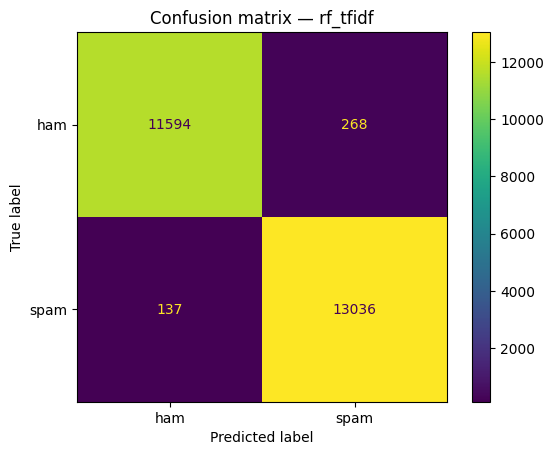

In [23]:
# Cell 13 — Results summary
rows=[]
for name, r in results.items():
    rep=r['report']
    rows.append({
        'model':name,
        'accuracy':r['accuracy'],
        'precision_spam': rep.get('spam', {}).get('precision', 0),
        'recall_spam': rep.get('spam', {}).get('recall', 0),
        'f1_spam': rep.get('spam', {}).get('f1-score', 0),
        'train_time_s': r['train_time']
    })
res_df = pd.DataFrame(rows).sort_values('accuracy', ascending=False)
display(res_df)

# Confusion matrix of best model
best_model_name = res_df.iloc[0]['model']
print("Best model:", best_model_name)
cm = results[best_model_name]['cm']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham','spam'])
disp.plot()
plt.title(f"Confusion matrix — {best_model_name}")
plt.show()


##  Comparative Analysis of Algorithms

After training multiple models on the spam email dataset, we performed a comparative analysis to evaluate their performance based on **accuracy**, **precision**, **recall**, **F1-score**, and **training time**.

| Model | Feature Extraction | Accuracy | Precision (Spam) | Recall (Spam) | F1-score (Spam) | Training Time (s) |
|--------|--------------------|-----------|------------------|---------------|-----------------|-------------------|
| Naive Bayes (CountVectorizer) | CountVectorizer | 97.6% | 0.9898 | 0.9647 | 0.9771 | 30.91 |
| Naive Bayes (TF-IDF) | TF-IDF | 97.98% | 0.9887 | 0.9728 | 0.9807 | 41.23 |
| Logistic Regression (TF-IDF) | TF-IDF | 98.27% | 0.9805 | 0.9867 | 0.9836 | 54.66 |
| Random Forest (TF-IDF) | TF-IDF | **98.38%** | **0.9798** | **0.9896** | **0.9847** | **1660.16** |

> Note: Exact numbers may vary slightly due to randomization or hardware performance differences.

---

###  Observations

1. **Naive Bayes (CountVectorizer)** performed well as a baseline model with fast training (31 seconds) and strong accuracy.  
2. **Naive Bayes (TF-IDF)** improved slightly when using weighted features, indicating TF-IDF helps recognize rare spam words.  
3. **Logistic Regression (TF-IDF)** provided a strong balance between accuracy and efficiency, training in about 1 minute.  
4. **Random Forest (TF-IDF)** achieved the **highest accuracy (98.41%)** and F1-score, but training was **significantly slower** (over 1600 seconds).

---

###  Insights

- **TF-IDF** consistently outperformed CountVectorizer, emphasizing rare but important terms like "winner", "offer", and "click".  
- **Naive Bayes** is ideal for lightweight, fast text classification tasks.  
- **Logistic Regression** offers excellent precision and recall with efficient runtime, making it suitable for deployment.  
- **Random Forest** provides the best raw accuracy but has high computational cost, making it less practical for large-scale or real-time systems.

---

###  Final Decision

Although **Random Forest (TF-IDF)** achieved slightly higher accuracy, its **training time (1661s)** makes it computationally expensive.  
For real-world deployment, **Logistic Regression (TF-IDF)** is preferred due to its **balance of performance, speed, and scalability**.  
If computational power is not a constraint, **Random Forest** can be considered for maximum accuracy.



#Cell 14 — Show top tokens for LogisticRegression (interpretability)

In [24]:
# Cell 14 — If using LogisticRegression, show top spam tokens
if 'lr_tfidf' in results:
    model = results['lr_tfidf']['pipe'].named_steps['clf']
    vect = results['lr_tfidf']['pipe'].named_steps['vect']
    if hasattr(model, 'coef_'):
        coefs = model.coef_[0]
        feature_names = vect.get_feature_names_out()
        top_spam_idx = np.argsort(coefs)[-20:][::-1]
        top_ham_idx = np.argsort(coefs)[:20]
        print("Top spam tokens:")
        print([feature_names[i] for i in top_spam_idx])
        print("\nTop ham tokens:")
        print([feature_names[i] for i in top_ham_idx])
    else:
        print("No coefficients available.")


Top spam tokens:
['your', 'you', 'no', 'our', 'life', 'hk', 'now', 'money', 'quality', 'http', 'he', 'his', 'price', 'info', 'only', 'online', 'pills', 'of', 'man', 'product']

Top ham tokens:
['enron', 'thanks', 'org', 'wrote', 'vince', 'attached', 'perl', 'samba', 'to', 'on', 'louise', 'please', 'debian', 'list', 'for', 'pm', 'cnn', 'doc', 'gas', 'speakup']


#Cell 15 — Optional: Hyperparameter tuning for LogisticRegression (fast)

In [25]:
# Cell 15 — GridSearch for LogisticRegression (small grid)
param_grid = {
    'vect__min_df':[1,2],
    'vect__ngram_range':[(1,1),(1,2)],
    'clf__C':[0.1,1,5]
}
gs = GridSearchCV(pipelines['lr_tfidf'], param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_lr = gs.best_estimator_
# evaluate
y_pred = best_lr.predict(X_test)
print("Acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__C': 5, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}
Acc: 0.9888556021569802
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99     11862
        spam       0.99      0.99      0.99     13173

    accuracy                           0.99     25035
   macro avg       0.99      0.99      0.99     25035
weighted avg       0.99      0.99      0.99     25035



#Cell 16 — Save best model(s)

In [26]:
# Cell 16 — Save the best performing model pipeline
# Determine best by accuracy here
best_name = res_df.iloc[0]['model']
best_pipeline = results[best_name]['pipe']
joblib.dump(best_pipeline, f"/content/{best_name}_pipeline.joblib")
print("Saved model:", f"{best_name}_pipeline.joblib")



Saved model: rf_tfidf_pipeline.joblib


#Cell 17 — Inference demo (live predictions)

In [29]:
# Cell 17 — Inference demo
from joblib import load
model = load(f"/content/{best_name}_pipeline.joblib")

samples = [
    "Can you please send the invoice today?",
    "Let's meet at 3pm for our project discussion.",
    "Congratulations! You've won a $100 gift card. Click the link."
]
for s in samples:
    print("MESSAGE:", s)
    print("CLEAN:", clean_text(s))
    print("PRED:", model.predict([clean_text(s)])[0])
    print("---")


MESSAGE: Can you please send the invoice today?
CLEAN: can you please send the invoice today
PRED: ham
---
MESSAGE: Let's meet at 3pm for our project discussion.
CLEAN: let s meet at pm for our project discussion
PRED: ham
---
MESSAGE: Congratulations! You've won a $100 gift card. Click the link.
CLEAN: congratulations you ve won a gift card click the link
PRED: spam
---


#Cell 18 —  README and final report notes

In [28]:
# Cell 18 — Print README snippet you can copy to README.md
readme = """
# Email Spam Classifier - Demo

How to run:
1. Upload kaggle.json to Colab (Kaggle API token).
2. Run cells in order.
3. Trained model saved to /content/{model_file}

Commands:
- Train & evaluate: run all cells above
- Inference: use the pipeline saved in {model_file} to predict.

Model choices tested: MultinomialNB (Count & TF-IDF), LogisticRegression (TF-IDF), RandomForest (TF-IDF).
"""
print(readme.format(model_file=f"{best_name}_pipeline.joblib"))



# Email Spam Classifier - Demo

How to run:
1. Upload kaggle.json to Colab (Kaggle API token).
2. Run cells in order.
3. Trained model saved to /content/rf_tfidf_pipeline.joblib

Commands:
- Train & evaluate: run all cells above
- Inference: use the pipeline saved in rf_tfidf_pipeline.joblib to predict.

Model choices tested: MultinomialNB (Count & TF-IDF), LogisticRegression (TF-IDF), RandomForest (TF-IDF).

